#Credits to Darien Schettler

In [1]:
print("\n... IMPORTS STARTING ...\n")
print("\n\tVERSION INFORMATION")

# Parallel application across pandas apply operation
!pip install pandarallel
from pandarallel import pandarallel
pandarallel.initialize()

# Machine Learning and Data Science Imports
import tensorflow as tf; print(f"\t\t– TENSORFLOW VERSION: {tf.__version__}");
import tensorflow_addons as tfa; print(f"\t\t– TENSORFLOW ADDONS VERSION: {tfa.__version__}");
import pandas as pd; pd.options.mode.chained_assignment = None;
import numpy as np; print(f"\t\t– NUMPY VERSION: {np.__version__}");

# Built In Imports
from kaggle_datasets import KaggleDatasets
from collections import Counter
from datetime import datetime
import multiprocessing as mp
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from glob import glob
import warnings
import requests
import imageio
import IPython
import urllib
import zipfile
import pickle
import random
import shutil
import string
import math
import time
import gzip
import ast
import io
import os
import gc
import re

# Visualization Imports
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm; tqdm.pandas();
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib; print(f"\t\t– MATPLOTLIB VERSION: {matplotlib.__version__}");
import plotly
import PIL
import cv2


print("\n\n... IMPORTS COMPLETE ...\n")


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "... Physical GPUs,", len(logical_gpus), "Logical GPUs ...\n")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


... IMPORTS STARTING ...


	VERSION INFORMATION
  Created wheel for pandarallel: filename=pandarallel-1.5.2-py3-none-any.whl size=18384 sha256=6d91d05ff9843d3f19cc523cf73cbfe6de124fded2ae49a2e34d8a8127f8915f
  Stored in directory: /root/.cache/pip/wheels/b5/6d/51/9ece2eaf007ea3f7fb0ce053c5773b2eb0d308887da3af12c1
Successfully built pandarallel
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
		– TENSORFLOW VERSION: 2.4.1
		– TENSORFLOW ADDONS VERSION: 0.12.1
		– NUMPY VERSION: 1.19.5
		– MATPLOTLIB VERSION: 3.4.1


... IMPORTS COMPLETE ...



In [2]:
# Only required if `APPLY_TOKENIZATION=True`
TOKEN_LIST = ["<PAD>", "InChI=1S/", "<END>", "/c", "/h", "/m", "/t", "/b", "/s", "/i"] +\
             ['Si', 'Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'C', 'H', 'B', ] +\
             [str(i) for i in range(167,-1,-1)] +\
             ["\+", "\(", "\)", "\-", ",", "D", "T"]

START_TOKEN = tf.constant(TOKEN_LIST.index("InChI=1S/"), dtype=tf.uint8)
END_TOKEN = tf.constant(TOKEN_LIST.index("<END>"), dtype=tf.uint8)
PAD_TOKEN = tf.constant(TOKEN_LIST.index("<PAD>"), dtype=tf.uint8)

# Define the root and data directories
ROOT_DIR = "/kaggle/input"
DATA_DIR = os.path.join(ROOT_DIR, "bms-molecular-translation")

TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

TRAIN_CSV_PATH = "/kaggle/input/bms-csvs-w-extra-metadata/train_labels_w_extra.csv"
SS_CSV_PATH = "/kaggle/input/bms-csvs-w-extra-metadata/sample_submission_w_extra.csv"

train_df = pd.read_csv(TRAIN_CSV_PATH)
train_df.roi_bbox = train_df.roi_bbox.progress_apply(lambda x: ast.literal_eval(x))

print("\n... TRAIN DATAFRAME W/ PATHS ...\n")
display(train_df)

ss_df = pd.read_csv(SS_CSV_PATH)
ss_df.roi_bbox = ss_df.roi_bbox.progress_apply(lambda x: ast.literal_eval(x))

print("\n... SUBMISSION DATAFRAME ...\n")
display(ss_df)

  0%|          | 0/2344186 [00:00<?, ?it/s]


... TRAIN DATAFRAME W/ PATHS ...



,image_id,InChI,img_path,inchi_token_len,roi_bbox,crop_width,crop_height,aspect_ratio
0,086e77fe6edf,InChI=1S/C21H25N3O2S/c1-5-6-16-13-18(27-14(16)...,/kaggle/input/bms-molecular-translation/train/...,97,"(24, 23, 237, 184)",213,161,1.322981
1,086e891d2e10,"InChI=1S/C25H27N5O3/c1-25(2,3)33-24(31)29-14-1...",/kaggle/input/bms-molecular-translation/train/...,106,"(23, 23, 333, 200)",310,177,1.751412
2,086e8f6bc917,InChI=1S/C16H15N3O2/c1-11-7-13-16(17-9-11)19(1...,/kaggle/input/bms-molecular-translation/train/...,82,"(39, 38, 329, 270)",290,232,1.250000
3,086e91208d0e,InChI=1S/C11H11N3O4/c12-13-8-3-1-7(2-4-8)11(17...,/kaggle/input/bms-molecular-translation/train/...,64,"(38, 38, 367, 196)",329,158,2.082278
4,086e9c449a4f,InChI=1S/C12H17N3OS/c1-4-7-10-11(17-14-13-10)1...,/kaggle/input/bms-molecular-translation/train/...,62,"(23, 23, 207, 125)",184,102,1.803922
...,...,...,...,...,...,...,...,...
2344181,ffffe824f539,InChI=1S/C10H12F2N2O3/c1-17-7-2-5(3-8(15)16)9(...,/kaggle/input/bms-molecular-translation/train/...,72,"(23, 23, 164, 143)",141,120,1.175000
2344182,ffffea1ebdfa,InChI=1S/C19H20F2N4O3S/c1-10(8-20)28-14-7-12(2...,/kaggle/input/bms-molecular-translation/train/...,120,"(38, 38, 519, 232)",481,194,2.479381
2344183,ffffee2b4534,InChI=1S/C22H26Cl2N2O4S/c1-16-6-2-3-10-21(16)3...,/kaggle/input/bms-molecular-translation/train/...,115,"(38, 38, 564, 190)",526,152,3.460526
2344184,fffff0b6eea6,InChI=1S/C17H26N2O6S/c1-23-16-12-14(4-5-15(16)...,/kaggle/input/bms-molecular-translation/train/...,91,"(23, 23, 354, 139)",331,116,2.853448


  0%|          | 0/1616107 [00:00<?, ?it/s]


... SUBMISSION DATAFRAME ...



,image_id,InChI,img_path,roi_bbox,crop_width,crop_height,aspect_ratio
0,00000d2a601c,InChI=1S/H2O/h1H2,/kaggle/input/bms-molecular-translation/test/0...,"(38, 1, 318, 205)",280,204,1.372549
1,00001f7fc849,InChI=1S/H2O/h1H2,/kaggle/input/bms-molecular-translation/test/0...,"(38, 38, 226, 401)",188,363,0.517906
2,000037687605,InChI=1S/H2O/h1H2,/kaggle/input/bms-molecular-translation/test/0...,"(38, 38, 297, 349)",259,311,0.832797
3,00004b6d55b6,InChI=1S/H2O/h1H2,/kaggle/input/bms-molecular-translation/test/0...,"(38, 15, 382, 228)",344,213,1.615023
4,00004df0fe53,InChI=1S/H2O/h1H2,/kaggle/input/bms-molecular-translation/test/0...,"(36, 19, 177, 255)",141,236,0.597458
...,...,...,...,...,...,...,...
1616102,ffffcdb2e39e,InChI=1S/H2O/h1H2,/kaggle/input/bms-molecular-translation/test/f...,"(38, 38, 492, 198)",454,160,2.837500
1616103,ffffcfddd770,InChI=1S/H2O/h1H2,/kaggle/input/bms-molecular-translation/test/f...,"(38, 38, 292, 442)",254,404,0.628713
1616104,ffffe4ab06b2,InChI=1S/H2O/h1H2,/kaggle/input/bms-molecular-translation/test/f...,"(38, 38, 360, 217)",322,179,1.798883
1616105,ffffec4033ec,InChI=1S/H2O/h1H2,/kaggle/input/bms-molecular-translation/test/f...,"(38, 38, 195, 462)",157,424,0.370283


In [3]:
N_TEST = len(ss_df) # 1616107

N_TRAIN, N_VAL = train_test_split(train_df, test_size=0.0345, random_state=2021)

# Whether to rotate images 90 degrees based on the w/h rule
# Only True for test images
FIX_ROTATION = True

# Whether to invert foreground/background
DO_INVERT = True

# Whether to repair images - not implemented yet
DO_REPAIR = False

# Desired image shape ... the last axis indicates whether to tile the single channel image to 3
IMG_SHAPE = (192,384,1)

# Whether or not to do tokenization to inchi strings
APPLY_TOKENIZATION = True

In [4]:
# INCHI RELATED
TOK2INT = {c.strip("\\"):i for i,c in enumerate(TOKEN_LIST)}
INT2TOK = {v:k for k,v in TOK2INT.items()}

FILTER_ON_MAX_LEN=False
MAX_LEN = train_df.inchi_token_len.max()+1 # +1 is for the end token
VOCAB_LEN = len(INT2TOK)

# IMG RELATED
N_CHANNELS = IMG_SHAPE[-1]
IMG_SIZE = IMG_SHAPE[:2]

val_df = N_VAL.reset_index(drop=True)
train_df = N_TRAIN.reset_index(drop=True)

N_TRAIN = len(N_TRAIN)
N_VAL = len(N_VAL)

print(N_TRAIN)
print(N_VAL)

# For TFRecord sharding - very rough estimations
N_EX_PER_REC = (20000 if np.product(IMG_SHAPE)>400000 else 40000)

2263311
80875


In [5]:
display(train_df.head())
display(val_df.head())

,image_id,InChI,img_path,inchi_token_len,roi_bbox,crop_width,crop_height,aspect_ratio
0,8ad174f77ebf,InChI=1S/C17H19NO3S/c1-3-6-14-9-11-15(12-10-14...,/kaggle/input/bms-molecular-translation/train/...,80,"(38, 38, 428, 193)",390,155,2.516129
1,de3337163396,InChI=1S/C10H6F2O3S/c11-10(12)15-7-3-5-1-2-16-...,/kaggle/input/bms-molecular-translation/train/...,55,"(22, 23, 163, 134)",141,111,1.270270
2,3976827027c2,InChI=1S/C22H23ClN4O2/c1-29-21-9-3-15(10-18(21...,/kaggle/input/bms-molecular-translation/train/...,103,"(23, 23, 254, 234)",231,211,1.094787
3,772bb74770e5,InChI=1S/C12H19NO3S/c1-9-4-5-10(2)12(8-9)17(15...,/kaggle/input/bms-molecular-translation/train/...,70,"(23, 23, 212, 128)",189,105,1.800000
4,a8185e76eee4,InChI=1S/C11H12N2OS2/c1-7-12-6-9(16-7)11(14)10...,/kaggle/input/bms-molecular-translation/train/...,57,"(38, 38, 303, 183)",265,145,1.827586


,image_id,InChI,img_path,inchi_token_len,roi_bbox,crop_width,crop_height,aspect_ratio
0,13ea66f9ec5b,InChI=1S/C22H28FN3O2/c1-16-14-26(15-21(28-16)1...,/kaggle/input/bms-molecular-translation/train/...,101,"(23, 23, 352, 144)",329,121,2.719008
1,fc8f442ba363,InChI=1S/C25H25ClN4O2S/c1-3-15-32-24(31)21-17(...,/kaggle/input/bms-molecular-translation/train/...,108,"(47, 23, 235, 209)",188,186,1.010753
2,f666fd38f70d,InChI=1S/C13H14I3NO4/c1-2-17-13(20)10-7(14)6-8...,/kaggle/input/bms-molecular-translation/train/...,82,"(38, 38, 475, 175)",437,137,3.189781
3,61e1e3e9b7cc,InChI=1S/C18H27FN2O/c1-14(12-16-6-8-17(19)9-7-...,/kaggle/input/bms-molecular-translation/train/...,90,"(31, 26, 289, 119)",258,93,2.774194
4,53dd24c9b251,InChI=1S/C16H22N4S/c1-12-8-13-14(18-11-19-15(1...,/kaggle/input/bms-molecular-translation/train/...,79,"(23, 23, 190, 136)",167,113,1.477876


In [6]:
def flatten_l_o_l(nested_list):
    """ Flatten a list of lists """
    return [item for sublist in nested_list for item in sublist]


def tf_load_image(path, bbox, img_size=(224,224), tile_to_3_channel=True, invert=False, rotate_trick=True, repair_images=False):
    """ Load an image with the correct size and shape """
    img = decode_img(tf.io.read_file(path), bbox, img_size, n_channels=1, invert=invert, rotate_trick=rotate_trick, repair_images=repair_images)
    
    if tile_to_3_channel:
        return tf.tile(img, tf.constant((1, 1, 3), dtype=tf.int32))
    else:
        return img
    
def rotate_trick_fn(a):
    """ Pad a tensor array `a` evenly until it is a square """
    h_src = tf.shape(a)[0]
    w_src = tf.shape(a)[1] 
            
    if h_src>w_src: # pad width
        a = tf.image.rot90(a)

    return a
    
    
def decode_img(img, bbox, img_size=(224,224), n_channels=1, invert=False, rotate_trick=True, repair_images=False):
    """ Decode the image by utilizing TF ... pad to square ... and resize """
    
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=n_channels)
    img = tf.image.crop_to_bounding_box(img, bbox[1], bbox[0], bbox[3]-bbox[1], bbox[2]-bbox[0])
    
    if invert:
        img = tf.ones_like(img, dtype=tf.uint8)*255-img
        constant_pad=0
    else:
        constant_pad=255
        
    if repair_images:
        pass
        
    # rotate trick
    if rotate_trick:
        img = rotate_trick_fn(img)
            
    img = tf.image.resize(img, img_size, method="bilinear")
    return tf.cast(img, tf.uint8)


def tokens_to_str(caption_tokens, discard_padding=True):
    """ Should convert a string of token ids to an InChI string """
    if discard_padding:
        return "".join([int_2_char_lex[x] for x in caption_tokens if x!=len(int_2_char_lex)])
    else:
        return "".join([int_2_char_lex[x] for x in caption_tokens])
    
    
def evaluate(image, from_np=False):
    """ TBD """
    attention_plot = np.zeros((MAX_LEN, fixed_encoder.output_shape[1]))
    hidden = tf.zeros((1, RNN_UNITS), tf.float32)

    if not from_np:
        temp_input = tf.expand_dims(tf_load_image(image, img_size=INPUT_SHAPE[:-1]), 0)
        img_tensor_val = fixed_encoder(temp_input)
    else:
        img_tensor_val=image
    
    features = trainable_encoder(img_tensor_val)
    dec = tf.ones((1, 1), tf.uint8)
    result = [int_2_char_lex[1],]

    for i in range(MAX_LEN-1):
        predictions, hidden, attention_weights = dec_model([dec, hidden, features])
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(int_2_char_lex[predicted_id])
        if int_2_char_lex[predicted_id] == '<END>':
            return result, attention_plot

        dec = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


def plot_attention(image, result, attention_plot):
    """ TBD """    
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(18, 14))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.4, extent=img.get_extent())

    plt.tight_layout()
    plt.show()
    
def test_random_image(style="full"):
    """ TBD """    
    rid = np.random.randint(0, len(val_subset_df))
    path = val_subset_df["img_path"][rid]
    
    if style=="full":
        real_caption = val_subset_df["InChI"][rid][:-1]
    else:
        real_caption = val_subset_df["InChI_chem"][rid][:-1]

    result, attention_plot = evaluate(path)
    result = ''.join(result[:-1])
    print (f"\n\tReal Caption       : {real_caption}")
    print (f"\tPrediction Caption   : {result}")
    print(f"\tLevenshtein Distance  : {Levenshtein.distance(real_caption, result)}\n")
    plot_attention(path, result, attention_plot)

In [8]:
if APPLY_TOKENIZATION:
    print("\n... CREATING THE TOKENIZED INCHI LABEL ARRAYS STARTING ...\n")

    print("\n... STEP 1: ADDING STOP TOKEN `<END>` IF NECESSARY ...")
    if not train_df["InChI"][0].endswith("<END>"):
        train_df["InChI"] = train_df["InChI"]+"<END>"
        val_df["InChI"] = val_df["InChI"]+"<END>"
    
    print("\n... STEP 2: ITERATE OVER THE DATASET (OR LOAD FROM FILE) TO CONVERT STRING TO SPARSE TOKENIZED ENCODING ...")
    try:  
        with open('/kaggle/input/bms-simple-tfrecord-creation/train_captions_darien_tokenized.pickle', 'rb') as handle:
            train_captions = pickle.load(handle)
        with open('/kaggle/input/bms-simple-tfrecord-creation/val_captions_darien_tokenized.pickle', 'rb') as handle:
            val_captions = pickle.load(handle)
        print("\t--> LOADING CAPTIONS FROM FILE SUCCESSFUL")
    except:
        print("\t--> LOADING CAPTIONS FROM FILE UNSUCCESSFUL... GENERATING FROM SCRATCH")
        # Captions start as zeros because that is the padding token (by using zero we can mask it later)
        
        print("\t--> WORKING ON TRAIN CAPTIONS")
        train_captions = np.zeros((N_TRAIN, MAX_LEN,), dtype=np.uint8)    
        # Make the sparse, padded encodings for our captions 
        for i, inchi in tqdm(enumerate(train_df.InChI.values), total=N_TRAIN):
            sparse_rep = [TOK2INT[c] for c in re.findall("|".join(TOKEN_LIST), inchi)]
            train_captions[i, :len(sparse_rep)] = sparse_rep  

        print("\t--> WORKING ON VAL CAPTIONS")
        val_captions = np.zeros((N_VAL, MAX_LEN,), dtype=np.uint8)    
        # Make the sparse, padded encodings for our captions 
        for i, inchi in tqdm(enumerate(val_df.InChI.values), total=N_VAL):
            sparse_rep = [TOK2INT[c] for c in re.findall("|".join(TOKEN_LIST), inchi)]
            val_captions[i, :len(sparse_rep)] = sparse_rep  

    # print("\n... STEP 3: SAVE ARRAYS FOR FUTURE USE TO SAVE TIME IF USING THIS ENCODING ...")
    # Save for next time
    # with open('/kaggle/working/train_captions_darien_tokenized.pickle', 'wb') as handle:
        # pickle.dump(train_captions, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # with open('/kaggle/working/val_captions_darien_tokenized.pickle', 'wb') as handle:
        # pickle.dump(val_captions, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    train_captions = tf.cast(train_captions, tf.uint8)
    val_captions = tf.cast(val_captions, tf.uint8)
    
    print("\n\n... CREATING THE TOKENIZED INCHI LABEL ARRAYS COMPLETED ...\n")


... CREATING THE TOKENIZED INCHI LABEL ARRAYS STARTING ...


... STEP 1: ADDING STOP TOKEN `<END>` IF NECESSARY ...

... STEP 2: ITERATE OVER THE DATASET (OR LOAD FROM FILE) TO CONVERT STRING TO SPARSE TOKENIZED ENCODING ...
	--> LOADING CAPTIONS FROM FILE UNSUCCESSFUL... GENERATING FROM SCRATCH
	--> WORKING ON TRAIN CAPTIONS


  0%|          | 0/2263311 [00:00<?, ?it/s]

	--> WORKING ON VAL CAPTIONS


  0%|          | 0/80875 [00:00<?, ?it/s]



... CREATING THE TOKENIZED INCHI LABEL ARRAYS COMPLETED ...



In [9]:
def _bytes_feature(value, is_list=False):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    
    if not is_list:
        value = [value]
    
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _float_feature(value, is_list=False):
    """Returns a float_list from a float / double."""
        
    if not is_list:
        value = [value]
        
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value, is_list=False):
    """Returns an int64_list from a bool / enum / int / uint."""
        
    if not is_list:
        value = [value]
        
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def create_tf_dataset(df, is_test=False, tokenized_inchi=None):
    ds = tf.data.Dataset.from_tensor_slices(df["img_path"].values)
    ds_roi_bbox = tf.data.Dataset.from_tensor_slices([tf.constant(x) for x in tqdm(df["roi_bbox"].values)])
    ds = tf.data.Dataset.zip((ds, ds_roi_bbox))
    
    if is_test:
        return ds
    else:
        if tokenized_inchi is not None:
            target_ds = tf.data.Dataset.from_tensor_slices(tokenized_inchi)
        else:
            target_ds = tf.data.Dataset.from_tensor_slices(df["InChI"].values)
        return tf.data.Dataset.zip((ds, target_ds))       

def prep_tf_dataset_w_target(img_path, bbox, target, img_shape,
                             invert=True, 
                             rotate_trick=True, 
                             repair_images=False):
    
    img_tensor = tf_load_image(img_path, bbox,
                               img_size=img_shape[:2], 
                               tile_to_3_channel=img_shape[-1]==3, 
                               invert=invert, 
                               rotate_trick=rotate_trick, 
                               repair_images=repair_images)
    return img_tensor, target

def prep_tf_dataset_wo_target(img_path, bbox, img_shape,
                             invert=True, 
                             rotate_trick=True, 
                             repair_images=False):
    
    img_tensor = tf_load_image(img_path, bbox,
                               img_size=img_shape[:2], 
                               tile_to_3_channel=img_shape[-1]==3, 
                               invert=invert, 
                               rotate_trick=rotate_trick, 
                               repair_images=repair_images)
    img_id = tf.strings.split(tf.strings.split(img_path, ".png")[0], "/")[-1]
    return img_tensor, img_id

def serialize_raw(image, image_id, target=None):
    """
    Creates a tf.Example message ready to be written to a file from 4 features.

    Args:
        image (TBD): TBD
        image_id (str): TBD
        target (str): | delimited integers
    
    Returns:
        A tf.Example Message ready to be written to file
    """
    
    # Create a dictionary mapping the feature name to the 
    # tf.Example-compatible data type.
    feature = {'image': _bytes_feature(tf.io.encode_png(image), is_list=False)}
    
    if target is not None:
        feature["inchi"] = _bytes_feature(target, is_list=False)
    else:
        feature["image_id"] = _bytes_feature(image_id, is_list=False)
        
    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def serialize_tokenized(image, other, is_test=False):
    """
    Creates a tf.Example message ready to be written to a file from 4 features.

    Args:
        image (TBD): TBD
        other: Either the image_id or the target inchi
    
    Returns:
        A tf.Example Message ready to be written to file
    """
    # Create a dictionary mapping the feature name to the 
    # tf.Example-compatible data type.
    feature = {'image': _bytes_feature(tf.io.encode_png(image), is_list=False)}
    if not is_test:
        feature["inchi"] = _int64_feature(other, is_list=True)
    else:
        feature["image_id"] = _bytes_feature(other, is_list=False)
    
    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [10]:
train_ds = create_tf_dataset(train_df, tokenized_inchi=train_captions)
train_ds = train_ds.map(lambda x,y: (prep_tf_dataset_w_target(x[0], x[1], y, IMG_SHAPE, 
                                                              invert=DO_INVERT, 
                                                              rotate_trick=FIX_ROTATION, 
                                                              repair_images=DO_REPAIR)), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)


val_ds = create_tf_dataset(val_df, tokenized_inchi=val_captions)
val_ds = val_ds.map(lambda x,y: (prep_tf_dataset_w_target(x[0], x[1], y, IMG_SHAPE, 
                                                          invert=DO_INVERT, 
                                                          rotate_trick=FIX_ROTATION, 
                                                          repair_images=DO_REPAIR)), 
                    num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

test_ds = create_tf_dataset(ss_df, is_test=True)
test_ds = test_ds.map(lambda x,y: (prep_tf_dataset_wo_target(x, y, IMG_SHAPE, 
                                                           invert=DO_INVERT, 
                                                           rotate_trick=FIX_ROTATION, 
                                                           repair_images=DO_REPAIR)),
                      num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

  0%|          | 0/2263311 [00:00<?, ?it/s]

  0%|          | 0/80875 [00:00<?, ?it/s]

  0%|          | 0/1616107 [00:00<?, ?it/s]

In [11]:
def write_tfrecords(ds, n_ex, n_ex_per_rec=20000, serialize_fn=serialize_tokenized, out_dir="/kaggle/working/train_records", is_test=False):
    n_recs = int(np.ceil(n_ex/n_ex_per_rec))
    
    # Make dataset iterable
    ds = ds.as_numpy_iterator()
    
    # Create folder
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir, exist_ok=True)
        
    # Create tfrecords
    for i in tqdm(range(n_recs), total=n_recs):
        print(f"\n... Writing TFRecord {i+1} of {n_recs} ...\n")
        tfrec_path = os.path.join(out_dir, f"{out_dir.rsplit('_', 1)[1]}_{(i+1):02}_{n_recs:02}.tfrec")
        with tf.io.TFRecordWriter(tfrec_path) as writer:
            for ex in tqdm(range(n_ex_per_rec), total=n_ex_per_rec):
                try:
                    example = serialize_fn(*next(ds), is_test=is_test)
                    writer.write(example)
                except:
                    break
                    
print("\n... MAKING TRAINING TFRECORDS ...\n")
write_tfrecords(train_ds, N_TRAIN, N_EX_PER_REC, serialize_fn=serialize_tokenized, out_dir="/kaggle/working/train_records")
                    
print("\n... MAKING VALIDATION TFRECORDS ...\n")
write_tfrecords(val_ds, N_VAL, N_EX_PER_REC, serialize_fn=serialize_tokenized, out_dir="/kaggle/working/val_records")

#print("\n... MAKING TESTING TFRECORDS ...\n")
#write_tfrecords(test_ds, N_TEST, N_EX_PER_REC, serialize_fn=serialize_tokenized, out_dir="/kaggle/working/test_records", is_test=True)


... MAKING TRAINING TFRECORDS ...



  0%|          | 0/57 [00:00<?, ?it/s]


... Writing TFRecord 1 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 2 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 3 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 4 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 5 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 6 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 7 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 8 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 9 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 10 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 11 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 12 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 13 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 14 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 15 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 16 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 17 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 18 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 19 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 20 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 21 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 22 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 23 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 24 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 25 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 26 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 27 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 28 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 29 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 30 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 31 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 32 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 33 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 34 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 35 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 36 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 37 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 38 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 39 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 40 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 41 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 42 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 43 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 44 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 45 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 46 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 47 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 48 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 49 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 50 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 51 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 52 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 53 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 54 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 55 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 56 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 57 of 57 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... MAKING VALIDATION TFRECORDS ...



  0%|          | 0/3 [00:00<?, ?it/s]


... Writing TFRecord 1 of 3 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 2 of 3 ...



  0%|          | 0/40000 [00:00<?, ?it/s]


... Writing TFRecord 3 of 3 ...



  0%|          | 0/40000 [00:00<?, ?it/s]

In [12]:
def decode_records(serialized_example, is_test=False, is_tokenized=True, img_shape=(192,384,3)):
    """ Parses a set of features and label from the given `serialized_example`.
        
        It is used as a map function for `dataset.map`

    Args:
        serialized_example (tf.Example): A serialized example containing the
            following features:
                – sensor_feature_0 – [int64]
                – sensor_feature_1 – [int64]
                – sensor_feature_2 – [int64]
        is_test (bool, optional): Whether to allow for the label feature
        
    Returns:
        A decoded tf.data.Dataset object representing the tfrecord dataset
    """
    # Defaults are not specified since both keys are required.
    feature_dict = {
        'image': tf.io.FixedLenFeature(shape=[], dtype=tf.string),
    }
    
    if not is_test:
        if is_tokenized:
            feature_dict["inchi"] = tf.io.FixedLenFeature(shape=[MAX_LEN], dtype=tf.int64, default_value=[0]*MAX_LEN)
        else:
            feature_dict["inchi"] = tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value='')
    else:
        feature_dict['image_id'] = tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value='')
    
  
    # Define a parser
    features = tf.io.parse_single_example(serialized_example, features=feature_dict)
    
    image = decode_tf_ex_image(features['image'], resize_to=(*img_shape[:2], 3))
    if not is_test:
        target = features["inchi"]
        return image, target
    else:
        image_id = features["image_id"]
        return image, image_id
    
def decode_tf_ex_image(image_data, resize_to=(192,384,3)):
    image = tf.image.decode_png(image_data, channels=3)
    image = tf.reshape(image, resize_to)
    return tf.cast(image, tf.uint8)


... TRAIN CHECK ...



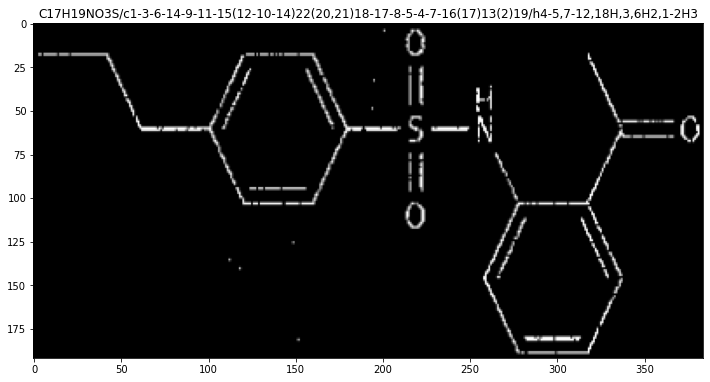


... VALIDATION CHECK ...



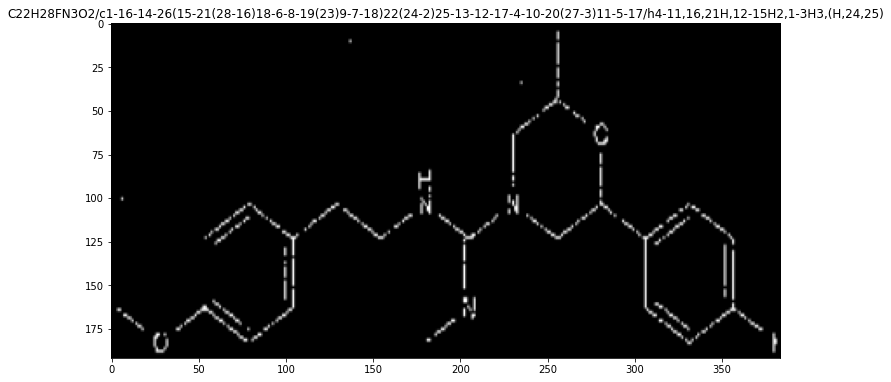

In [13]:
print("\n... TRAIN CHECK ...\n")
CHECK_TRAIN_TFREC_PATHS = sorted(tf.io.gfile.glob(f'/kaggle/working/train_records/*.tfrec'), key=lambda x: int(x[:-4].rsplit("_", 2)[1]))[:1]
check_train_ds = tf.data.TFRecordDataset(CHECK_TRAIN_TFREC_PATHS, num_parallel_reads=tf.data.AUTOTUNE)
check_train_ds = check_train_ds.map(lambda x: (decode_records(x, img_shape=IMG_SHAPE)), num_parallel_calls=tf.data.AUTOTUNE)
for x,y in check_train_ds.take(1):
    plt.figure(figsize=(12,12))
    plt.imshow(x)
    plt.title("".join([INT2TOK[c] for c in  y.numpy() if c not in [0,1,2]]))
    plt.show()

    
print("\n... VALIDATION CHECK ...\n")
CHECK_VAL_TFREC_PATHS = sorted(tf.io.gfile.glob(f'/kaggle/working/val_records/*.tfrec'), key=lambda x: int(x[:-4].rsplit("_", 2)[1]))[:1]
check_val_ds = tf.data.TFRecordDataset(CHECK_VAL_TFREC_PATHS, num_parallel_reads=tf.data.AUTOTUNE)
check_val_ds = check_val_ds.map(lambda x: (decode_records(x, img_shape=IMG_SHAPE)), num_parallel_calls=tf.data.AUTOTUNE)
for x,y in check_val_ds.take(1):
    plt.figure(figsize=(12,12))
    plt.imshow(x)
    plt.title("".join([INT2TOK[c] for c in  y.numpy() if c not in [0,1,2]]))
    plt.show()


# print("\n... TEST CHECK ...\n")
# CHECK_TEST_TFREC_PATHS = sorted(tf.io.gfile.glob(f'/kaggle/working/test_records/*.tfrec'), key=lambda x: int(x[:-4].rsplit("_", 2)[1]))[:1]
# check_test_ds = tf.data.TFRecordDataset(CHECK_TEST_TFREC_PATHS, num_parallel_reads=tf.data.AUTOTUNE)
# check_test_ds = check_test_ds.map(lambda x: (decode_records(x, img_shape=IMG_SHAPE, is_test=True)), num_parallel_calls=tf.data.AUTOTUNE)
# for x,y in check_test_ds.take(1):
#     plt.figure(figsize=(12,12))
#     plt.imshow(x)
#     plt.title(str(y.numpy().decode()))
#     plt.show()